# Load and preprocess images

1. `tf.keras.preprocessing`을 사용하는 방법 
2. `tf.data`를 사용하여 input pipeline을 직접 짜는 방법
3. TensorFlow Datasets에서 데이터셋을 다운받는 방법

## 꽃 데이터셋 다운로드

In [ ]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

In [ ]:
print(tf.__version__)

2.6.0


In [ ]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, 
                                   fname='flower_photos', 
                                   untar=True)
data_dir = pathlib.Path(data_dir)

In [ ]:
os.listdir(data_dir)

['daisy', 'sunflowers', 'LICENSE.txt', 'tulips', 'dandelion', 'roses']

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


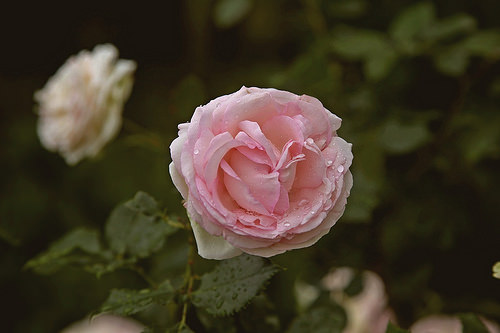

In [ ]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[1]))

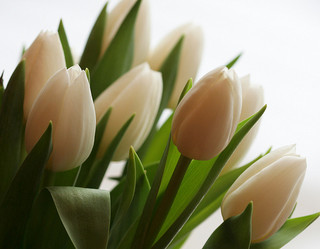

In [ ]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

## `tf.keras.preprocessing` 사용하기

`tf.keras.preprocessing` 유틸리티는 이미지 디렉토리에서 `tf.data.Dataset`을 생성하는 편리한 방법이다.

### 데이터셋 생성

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


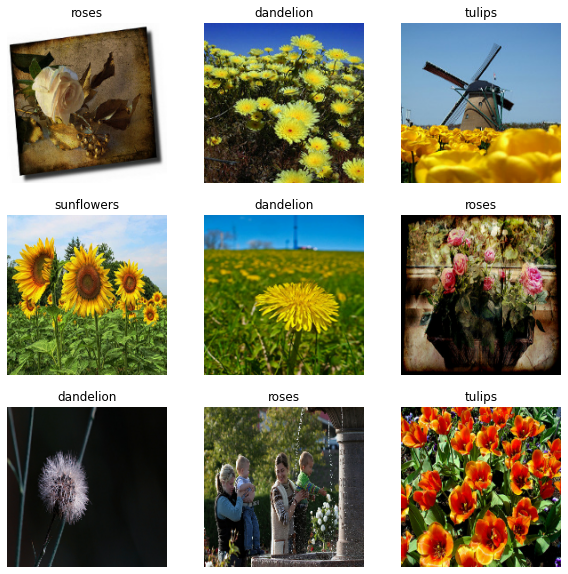

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


### 데이터 정규화

In [ ]:
# 0~255의 픽셀 값을 0~1로 정규화
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [ ]:
# map 함수로 데이터셋에 정규화 레이어 적용
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

print(np.min(first_image), np.max(first_image))

0.0 0.96902645


### 모델 훈련

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
num_classes = 5

model = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes)
])

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [ ]:
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
92/92 [==============================] - 39s 98ms/step - loss: 1.3303 - accuracy: 0.4329 - val_loss: 1.0900 - val_accuracy: 0.5518
Epoch 2/10
92/92 [==============================] - 4s 46ms/step - loss: 1.0679 - accuracy: 0.5702 - val_loss: 1.0402 - val_accuracy: 0.5777
Epoch 3/10
92/92 [==============================] - 4s 45ms/step - loss: 0.9337 - accuracy: 0.6277 - val_loss: 0.9440 - val_accuracy: 0.6240
Epoch 4/10
92/92 [==============================] - 4s 45ms/step - loss: 0.7776 - accuracy: 0.6958 - val_loss: 0.9211 - val_accuracy: 0.6335
Epoch 5/10
92/92 [==============================] - 4s 45ms/step - loss: 0.6001 - accuracy: 0.7772 - val_loss: 1.0707 - val_accuracy: 0.6213
Epoch 6/10
92/92 [==============================] - 4s 45ms/step - loss: 0.4601 - accuracy: 0.8355 - val_loss: 1.1289 - val_accuracy: 0.6226
Epoch 7/10
92/92 [==============================] - 4s 45ms/step - loss: 0.3366 - accuracy: 0.8770 - val_loss: 1.2380 - val_accuracy: 0.6444
Epoch 8/10
9

## `tf.data` 사용하기

세밀한 제어를 위해 `tf.keras.preprocessing` 대신 `tf.data`를 사용하여 input pipeline을 직접 작성할 수 있다.

### 데이터셋 생성

In [ ]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [ ]:
for f in list_ds.take(5):
    print(f.numpy())

b'/root/.keras/datasets/flower_photos/daisy/16291797949_a1b1b7c2bd_n.jpg'
b'/root/.keras/datasets/flower_photos/tulips/14054827092_f359f5fcbd_m.jpg'
b'/root/.keras/datasets/flower_photos/tulips/4520577328_a94c11e806_n.jpg'
b'/root/.keras/datasets/flower_photos/daisy/3861452393_14d2f95157_m.jpg'
b'/root/.keras/datasets/flower_photos/sunflowers/5139969631_743880e01d_n.jpg'


In [ ]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


In [ ]:
type(class_names[0])

numpy.str_

In [ ]:
# train, val split
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [ ]:
# length of each dataset
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

2936
734


파일 경로를 (img, label) 쌍으로 변환하는 함수 정의

In [ ]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    one_hot = parts[-2] == class_names
    # Integer encode the label
    return tf.argmax(one_hot)

In [ ]:
def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_jpeg(img, channels=3)
    # resize the image to the desired size
    return tf.image.resize(img, [img_height, img_width])

In [ ]:
def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

`Dataset.map`을 사용하여 image, label 쌍으로 이루어진 데이터셋 생성

In [ ]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [ ]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  1


In [ ]:
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

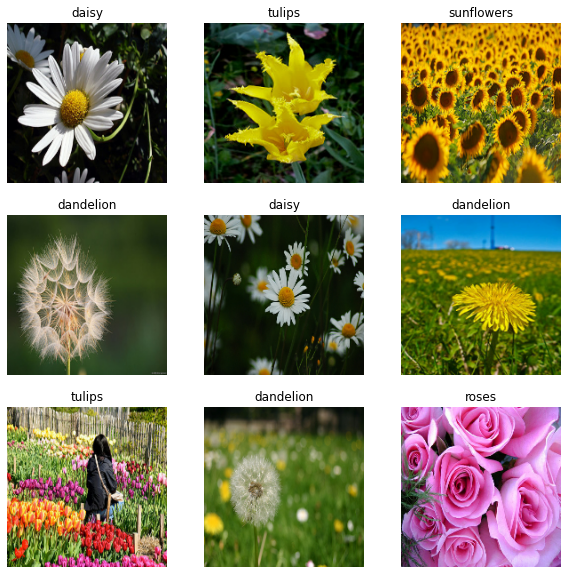

In [ ]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = label_batch[i]
    plt.title(class_names[label])
    plt.axis("off")

### 모델 훈련

In [ ]:
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
92/92 [==============================] - 11s 95ms/step - loss: 0.3679 - accuracy: 0.8907 - val_loss: 0.3210 - val_accuracy: 0.9142
Epoch 2/10
92/92 [==============================] - 4s 48ms/step - loss: 0.1226 - accuracy: 0.9619 - val_loss: 0.4389 - val_accuracy: 0.8937
Epoch 3/10
92/92 [==============================] - 4s 48ms/step - loss: 0.0529 - accuracy: 0.9874 - val_loss: 0.4189 - val_accuracy: 0.9005
Epoch 4/10
92/92 [==============================] - 4s 48ms/step - loss: 0.0261 - accuracy: 0.9952 - val_loss: 0.4588 - val_accuracy: 0.9046
Epoch 5/10
92/92 [==============================] - 4s 49ms/step - loss: 0.0130 - accuracy: 0.9976 - val_loss: 0.4987 - val_accuracy: 0.9087
Epoch 6/10
92/92 [==============================] - 4s 48ms/step - loss: 0.0108 - accuracy: 0.9986 - val_loss: 0.4968 - val_accuracy: 0.9033
Epoch 7/10
92/92 [==============================] - 4s 48ms/step - loss: 0.0107 - accuracy: 0.9990 - val_loss: 0.5126 - val_accuracy: 0.9019
Epoch 8/10
9

## TensorFlow Datasets 사용하기

- 위에서는 Flowers dataset을 디스크에 저장하여 로드하는 방법을 알아보았다.
- 아래와 같이 TensorFlow Datasets에서 데이터셋을 가져오는 방법도 있다.

### 데이터셋 생성

In [ ]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]


Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [ ]:
metadata

tfds.core.DatasetInfo(
    name='tf_flowers',
    version=3.0.1,
    description='A large set of images of flowers',
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
    }),
    total_num_examples=3670,
    splits={
        'train': 3670,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
    redistribution_info=,
)

In [ ]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


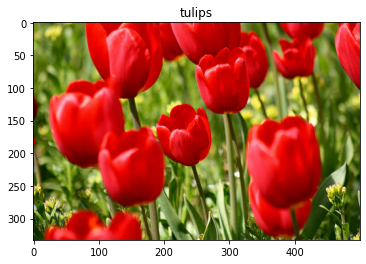

In [ ]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

In [ ]:
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)